\begin{center}
Gabe Morris
\end{center}

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve  # Numerical solver
from msu_esd import Pipe  # This is the first round of the package I'm making

# Note that the package is not yet stable, so expect backwards compatibility issues with this document.

plt.style.use(r'../maroon.mplstyle')  # Testing this out. This will make the plots MSU themed

\pagebreak
\tableofcontents
\pagebreak

\begin{center}
\begin{tabular}{c c c}
ME 6333 & Homework 1 & Gabe Morris \\
& & gnm54
\end{tabular}
\end{center}

# Problem 1
## Given
The operation of a pumped storage hydro facility is to be examined. The facility is composed of an upper reservoir, a lower reservoir, a turbine/generator, a motor/pump, and associated valves and controls. The overall strategy is to pump from the lower reservoir to the upper reservoir during periods of light electrical demand (typically nights) and cheap base-loaded rates and to generate electricity by flow from upper reservoir to lower during periods of high system demand (typically days and evenings). Pumped hydro facilities can be rapidly brought online when demand peaks and can be quickly shutdown when demand lessens.

\begin{center}
\includegraphics{images/Figure_1}
\end{center}

**Known Properties**

Tunnel Length: $7000\,ft$ \
Tunnel Diameter: $60\,ft$ \
Absolute Roughness ($\epsilon$): 0.$01\,ft$ \
Elevation Difference: $1250\,ft$ \
Minor Loss Fittings: 6 gate valves, 14 elbows, 10 ball valves \
Turbine/Generator Efficiency: 0.92 \
Motor/Pump Efficiency: 0.82

**Assumed Properties of Water**

Density: $\rho=1.94\,\frac{slugs}{ft^3}$ \
Dynamic Viscosity: $3.732\cdot 10^{-5}\frac{lb\cdot s}{ft^2}$

## Find
a. Find the maximum power that can be generated. Examine a range of flow rates: $50,000\frac{ft^3}{s}$ to $250,000\frac{ft^3}{s}$.
b. What flow rate produces the maximum power from the previous part?
c. If the pumping flow rate is the same as the generating flow rate, what is the pump power required?

## Solution
Start with the head form of the energy equation.

In [2]:
# Define symbols
P_in, P_out, V_in, V_out, z_in, z_out = sp.symbols('P_{in} P_{out} V_{in} V_{out} z_{in} z_{out}')
gamma, Ws, hf, g = sp.symbols(r'\gamma W_s h_f g')

# Define numerical values here to adjust if needed
# The underscore denotes a numerical value rather than sympy symbol
# Remember, everything must be in BG base units (mass in slugs)
L_ = 7000
D_ = 60
epsilon_ = 0.01
h = 1250
rho_ = 1.94
mu_ = 3.732e-5
g_ = 32.2

# Efficiencies
eta_turbine = 0.92  # Turbine efficiency
eta_pump = 0.82  # Pump efficiency

eq1 = sp.Eq(P_in/gamma + V_in**2/(2*g) + z_in, P_out/gamma + V_out**2/(2*g) + z_out + Ws/g + hf/g)
eq1

Eq(P_{in}/\gamma + V_{in}**2/(2*g) + z_{in}, P_{out}/\gamma + V_{out}**2/(2*g) + W_s/g + z_{out} + h_f/g)

A couple of things to note:

* The direction of the equation matters. This is why I prefer using the "in" and "out" subscripts.
* If we put everything in terms of the base units of the BG system, then we won't need to worry about the $g_c$. Keep in mind that the slug is the derived unit of the BG system (opposed to the Newton in the metric system): $slug=\frac{lbf\cdot s^2}{ft}=32.2\,lbm$.

Now we can make assumptions on the energy equation (if viewed in the case of the generator direction):

* The reservoirs are big which means that the velocity at the ends of the streamlines is negligible.
* The reservoirs are exposed to the same atmospheric pressure, which cancels them from the expression.
* The datum is set to the $z_{out}$ position.

In [3]:
# Making substitutions
eq2 = eq1.subs([
    (P_in, 0),
    (P_out, 0),
    (V_in, 0),
    (V_out, 0),
    (z_out, 0)
])
eq2

Eq(z_{in}, W_s/g + h_f/g)

In [4]:
# Solving for Ws
Ws_solved = sp.solve(eq2, Ws, dict=True)[0]
eq3 = sp.Eq(Ws, Ws_solved[Ws])
eq3

Eq(W_s, g*z_{in} - h_f)

This relationship above (stored in `eq3`) makes logical sense. This can be read that the work per unit mass from the fluid gets generated due to the initial elevation of the fluid, but some energy is lost due to the viscous effects of the pipe ($h_f$).

Now an expression for $h_f$ must be obtained ($h_f=K_{eq}\frac{V^2}{2}$). The major loss is,

$K_{major}=f\frac{L}{D}$.

The other $K$ factors for the minor losses are,

$K_{entrance}=0.5$ \
$K_{exit}=1$ \
$K_{gate}=8f_T$ \
$K_{elbow}=30f_T$ \
$K_{ball}=3f_T$

The values above assumed that the pipe diameter was constant through each valve and fitting ($\beta=1$ and $\theta=0$). The $K_{eq}$ then becomes,

$K_{eq}=K_{major}+K_{entrance}+K_{exit}+6K_{gate}+14K_{elbow}+10K_{ball}$

In [5]:
# Define more symbols and plug into expression
V, K_major, K_entrance, K_exit, K_gate, K_elbow, K_ball = sp.symbols('V K_{major} K_{entrance} K_{exit} K_{gate} K_{elbow} K_{ball}')

eq4 = eq3.subs(hf, V**2/2*(K_major + K_entrance + K_exit + 6*K_gate + 14*K_elbow + 10*K_ball))
eq4

Eq(W_s, -V**2*(10*K_{ball} + 14*K_{elbow} + K_{entrance} + K_{exit} + 6*K_{gate} + K_{major})/2 + g*z_{in})

In [6]:
# Substitute in the expressions for each K-factor
f, fT, L, D = sp.symbols('f f_T L D')

eq5 = eq4.subs([
    (K_major, f*L/D),
    (K_entrance, 0.5),
    (K_exit, 1),
    (K_gate, 8*fT),
    (K_elbow, 30*fT),
    (K_ball, 3*fT)
])
eq5

Eq(W_s, -V**2*(498*f_T + 1.5 + L*f/D)/2 + g*z_{in})

The goal is to get this in terms of the flow rate. Velocity can be rewritten in terms of the flow rate,

$V=\frac{Q}{A}=\frac{Q}{\frac{\pi}{4}D^2}$

In [7]:
# Substitute in the expression for velocity
Q = sp.Symbol('Q')

eq6 = eq5.subs(V, Q/(sp.pi/4*D**2))
eq6

Eq(W_s, g*z_{in} - 8*Q**2*(498*f_T + 1.5 + L*f/D)/(pi**2*D**4))

$f_T$ is a function of the relative roughness.

In [8]:
# Define an expression for fT and show before substituting
epsilon = sp.Symbol(r'\epsilon')

fT_expression = 0.3086/(sp.log((epsilon/(3.7*D))**1.11, 10))**2
fT_expression

0.3086*log(10)**2/log(0.234043231705236*(\epsilon/D)**1.11)**2

The above is displayed to show the expression before it gets substituted in. One **very important** note about `sympy`: logarithm expressions are always represented as natural logarithms. So in the expression above, $\log(...)=\ln(...)$. `sympy` does a change of base operation in the background.

In [9]:
# Substitute in the expression for fT
eq7 = eq6.subs(fT, fT_expression)
eq7

Eq(W_s, g*z_{in} - 8*Q**2*(1.5 + 153.6828*log(10)**2/log(0.234043231705236*(\epsilon/D)**1.11)**2 + L*f/D)/(pi**2*D**4))

The friction factor can be defined as a piecewise function that depends on the relative roughness and Reynold's number. Then Reynold's number can be written in terms of the flow rate, which will result in the work per unit mass being witten in terms of the flow rate and known constants.

In [10]:
# Writing the friction factor as a piecewise function.
# Haaland equation
Re = sp.Symbol('Re')

f_expression = sp.Piecewise((0.3086/(sp.log(6.9/Re + (epsilon/(D*3.7))**1.11, 10))**2, Re >= 2300), (64/Re, Re < 2300))
f_expression

Piecewise((0.3086*log(10)**2/log(0.234043231705236*(\epsilon/D)**1.11 + 6.9/Re)**2, Re >= 2300), (64/Re, True))

Now rewrite $Re$ in terms of the flow rate,

$Re=\frac{4\rho Q}{\pi D\mu}$

In [11]:
# Substitute the expression above into Re
rho, mu = sp.symbols(r'\rho \mu')

f_expression_ = f_expression.subs(Re, 4*rho*Q/(sp.pi*D*mu))
f_expression_

Piecewise((0.3086*log(10)**2/log(1.725*pi*D*\mu/(Q*\rho) + 0.234043231705236*(\epsilon/D)**1.11)**2, 4*Q*\rho/(pi*D*\mu) >= 2300), (16*pi*D*\mu/(Q*\rho), True))

Now substitute the above expression into `eq7` to finally write the energy per unit mass in terms of the flow rate.

In [12]:
eq8 = eq7.subs(f, f_expression_)
eq8

Eq(W_s, g*z_{in} - 8*Q**2*(1.5 + 153.6828*log(10)**2/log(0.234043231705236*(\epsilon/D)**1.11)**2 + L*Piecewise((0.3086*log(10)**2/log(1.725*pi*D*\mu/(Q*\rho) + 0.234043231705236*(\epsilon/D)**1.11)**2, 4*Q*\rho/(pi*D*\mu) >= 2300), (16*pi*D*\mu/(Q*\rho), True))/D)/(pi**2*D**4))

In [13]:
# Substituting in numerical values
eq9 = eq8.subs([
    (g, g_),
    (z_in, h),
    (epsilon, epsilon_),
    (D, D_),
    (mu, mu_),
    (rho, rho_),
    (L, L_)
])
eq9.n()

Eq(W_s, -6.25439405199616e-8*Q**2*(116.666666666667*Piecewise((1.63616575689363/log(1.49812550702357e-5 + 0.0019910412371134*pi/Q)**2, 3465.52340121472*Q/pi >= 2300), (0.0580177671745836/Q, True)) + 8.10281790872477) + 40250.0)

In [14]:
# Now convert the symbolic function into a python function for fast computing
Ws_lamb = sp.lambdify(Q, eq9.rhs, modules="numpy")

### Part A
Now that there is an explicit $W_s(Q)$, the power that the system produces may now be calculated. Consider the following relationships:

$\Delta P=\rho W_s$ \
$power=Q\Delta P=\rho QW_s$

The efficiency of a turbine is defined as the power transmitted to the shaft divided by the power transmitted by the fluid. The power in the above expression is that which is transmitted by the fluid, and we are interested in the output power extended to the shaft.

$power_{shaft}=\eta_T\cdot power_{fluid}$

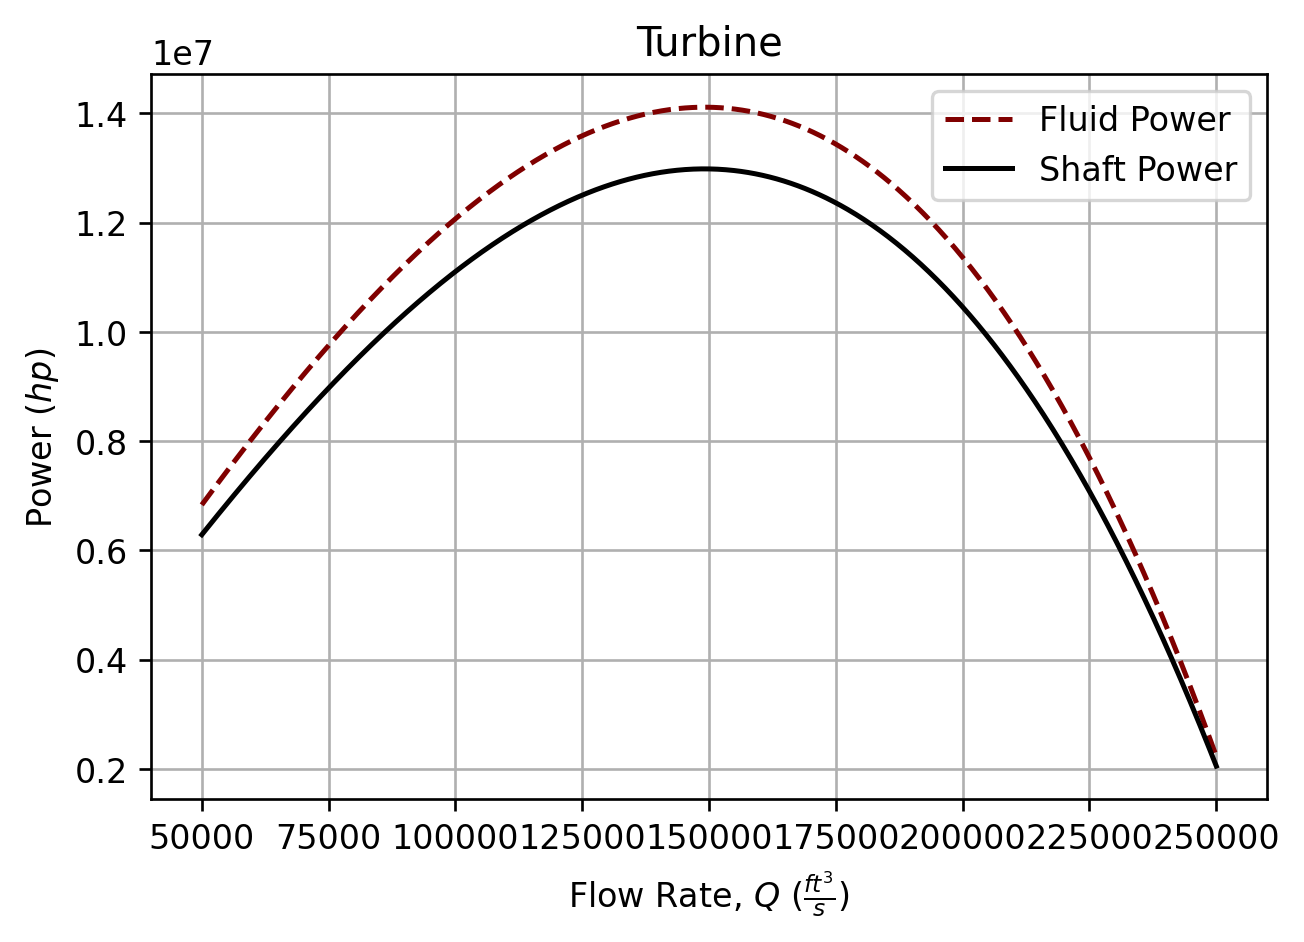

In [15]:
# Obtain the power of the shaft
flow_rates = np.linspace(50_000, 250_000, 1000)
power_fluid = rho_*flow_rates*Ws_lamb(flow_rates)/550  # In hp
power_shaft = eta_turbine*power_fluid  # In hp

# Start plotting
fig, ax = plt.subplots()
ax.plot(flow_rates, power_fluid, label='Fluid Power', ls='--')
ax.plot(flow_rates, power_shaft, label='Shaft Power')
ax.set_xlabel(r'Flow Rate, $Q$ ($\frac{ft^3}{s}$)')
ax.set_ylabel(r'Power ($hp$)')
ax.set_title('Turbine')
ax.legend()
plt.show()

The dashed line above represents the power that the turbine would generate if there was 100% efficiency.

In [16]:
max_power_gen = np.max(power_shaft)
print(f'The maximum power is {max_power_gen} horse power.')

The maximum power is 12982477.769300656 horse power.


### Part B
The flow rate that corresponds to the maximum power should be around $150,000\frac{ft^3}{s}$, but we can get a more precise answer by finding the index of the array that corresponds the maximum power.

In [17]:
max_power_flow_rate = flow_rates[power_shaft == max_power_gen][0]
print(f'The maximum power generated occurs at a flow rate of {max_power_flow_rate} cfs.')

The maximum power generated occurs at a flow rate of 149099.0990990991 cfs.


### Part C
We can start with the original energy equation, but make the $W_s$ negative because work is being done on the system.

In [18]:
eq10 = eq1.subs(Ws, -Ws)
eq10

Eq(P_{in}/\gamma + V_{in}**2/(2*g) + z_{in}, P_{out}/\gamma + V_{out}**2/(2*g) - W_s/g + z_{out} + h_f/g)

The same assumptions can be made as before, but this time, the datum will be set to $z_{in}$.

In [19]:
eq11 = eq10.subs([
    (P_in, 0),
    (P_out, 0),
    (V_in, 0),
    (V_out, 0),
    (z_in, 0)
])
eq11

Eq(0, -W_s/g + z_{out} + h_f/g)

In [20]:
# Solve for Ws
eq12 = sp.Eq(Ws, sp.solve(eq11, Ws)[0])
eq12

Eq(W_s, g*z_{out} + h_f)

This representation of the work per unit mass of the pump also makes logical sense. This can be interpreted that the pump will have to overcome the elevation difference, and the major and minor losses. Expect to see greater magnitudes of power for the pump compared to the power generated by a turbine, especially when there is a pump efficiency of 82%.

In [21]:
# Getting the same hf expression from before
hf_expression = (eq9.rhs - g_*h)*-1
hf_expression.n()

6.25439405199616e-8*Q**2*(116.666666666667*Piecewise((1.63616575689363/log(1.49812550702357e-5 + 0.0019910412371134*pi/Q)**2, 3465.52340121472*Q/pi >= 2300), (0.0580177671745836/Q, True)) + 8.10281790872477)

In [22]:
# Get new expression in terms of Q
eq13 = eq12.subs([
    (hf, hf_expression),
    (g, g_),
    (z_out, h)
])
eq13.n()

Eq(W_s, 6.25439405199616e-8*Q**2*(116.666666666667*Piecewise((1.63616575689363/log(1.49812550702357e-5 + 0.0019910412371134*pi/Q)**2, 3465.52340121472*Q/pi >= 2300), (0.0580177671745836/Q, True)) + 8.10281790872477) + 40250.0)

In [23]:
Ws_pump_lamb = sp.lambdify(Q, eq13.rhs, modules='numpy')

The efficiency for a pump is defined as the ratio of the power from the fluid to the power transmitted from the shaft to the fluid.

$power_{shaft}=\frac{power_{fluid}}{\eta_P}$

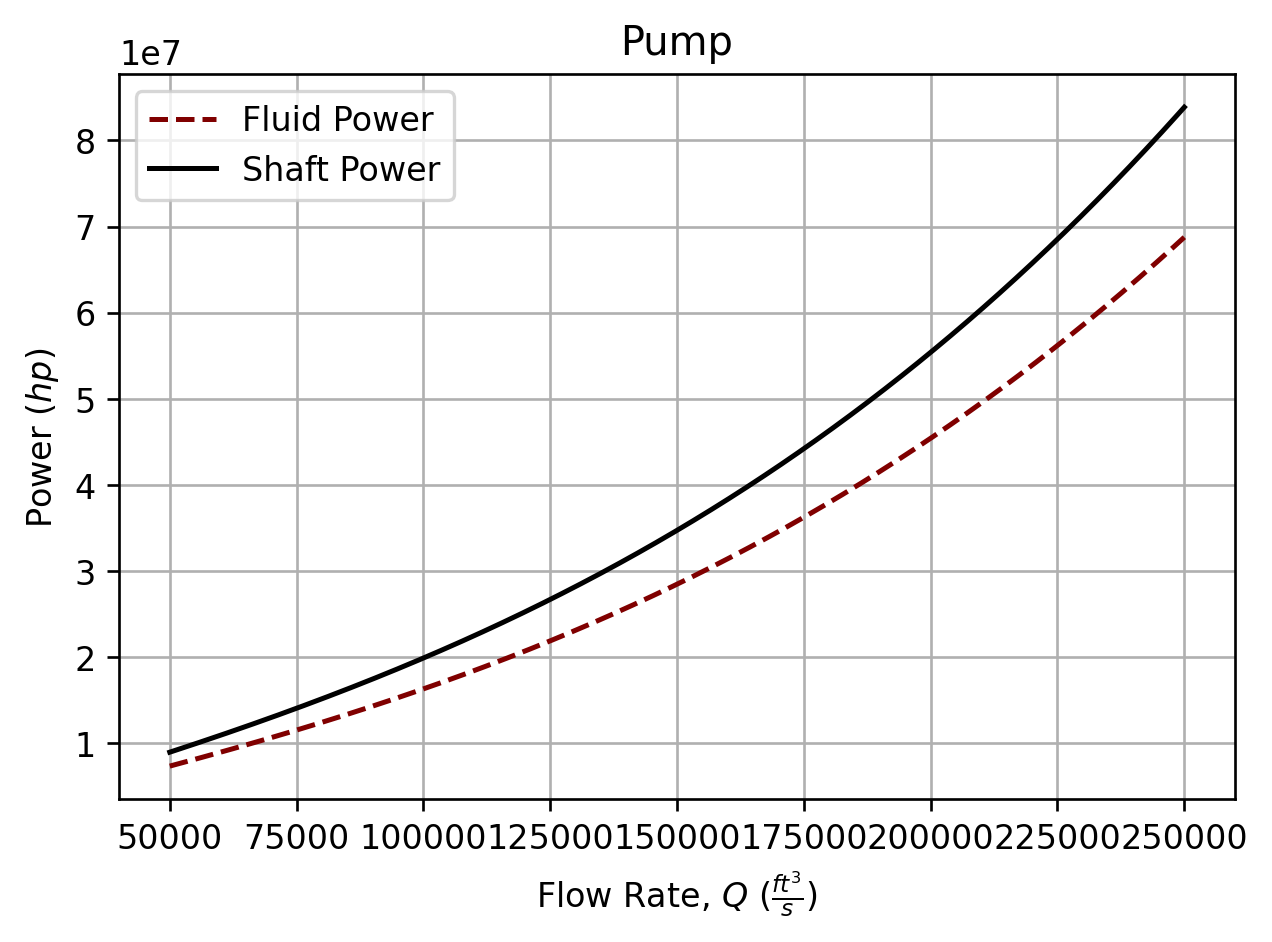

In [24]:
# Power
power_fluid_pump = rho_*flow_rates*Ws_pump_lamb(flow_rates)/550  # In hp
power_shaft_pump = power_fluid_pump/eta_pump

# Start plotting
fig2, ax2 = plt.subplots()
ax2.plot(flow_rates, power_fluid_pump, label='Fluid Power', ls='--')
ax2.plot(flow_rates, power_shaft_pump, label='Shaft Power')
ax2.set_xlabel(r'Flow Rate, $Q$ ($\frac{ft^3}{s}$)')
ax2.set_ylabel(r'Power ($hp$)')
ax2.set_title('Pump')
ax2.legend()
plt.show()

The above graph may be interpreted that the solid line is the shaft power required to push the fluid at the corresponding flow rate. The dashed line represents a 100% pump efficiency in which the pump won't have to work as hard.

In [25]:
# Getting the pump power at a flow rate of 150,000 cfs
power_fluid_150 = rho_*150_000*Ws_pump_lamb(150_000)/550  # In hp
power_shaft_150 = power_fluid_150/eta_pump
print(f'The power required from the shaft to push the fluid at 150,000 cfs is {power_shaft_150} horse power.')

The power required from the shaft to push the fluid at 150,000 cfs is 34733184.661962755 horse power.


## Answer
a. The maximum power that can be generated is around $1.3\cdot 10^7\,hp$.
b. The flow rate for which the maximum power generated occurs is $150,000\,\frac{ft^3}{s}$.
c. If a pump is used, the power required to push the fluid $150,000\,\frac{ft^3}{s}$ is around $3.5\cdot 10^7\,hp$.

## Verification
The above is a detailed example of the process. This process has been captured in my package, `msu_esd`.

In [26]:
# Define a pipe object for the turbine
turbine_pipe = Pipe(60, 7000, 0.01, 1.94, 3.732*10**-5, K=1.5, C=498, z_in=1250, eta=0.92, turbine=True)
np.max(turbine_pipe.power(flow_rates))/550

12966752.965041839

In [27]:
# Define a pipe object for the pump
pump_pipe = Pipe(60, 7000, 0.01, 1.94, 3.732*10**-5, K=1.5, C=498, z_out=1250, eta=0.82, pump=True)
pump_pipe.power(150_000)/550

34712214.59544393

\pagebreak

\begin{center}
\begin{tabular}{c c c}
ME 6333 & Homework 1 & Gabe Morris \\
& & gnm54
\end{tabular}
\end{center}

# Problem 2
## Given
A 14-inch (nominal) schedule 40 cast-iron pipe is used to convey 12 million gallons per day of benzene. The pipeline is 3 miles long, the pump motor is 39% efficient, and electricity costs 7.5 cents per kWh. An arrangement with a 12-inch and a 16-inch line in parallel with the existing 14-inch line is to be investigated.

## Find
a. What is the yearly pumping cost for the single pipe?
b. What is the yearly pumping cost for the parallel arrangement?
c. Work parts (a) and (b) if three filters, each with a loss coefficient of 150, are placed in the lines. For part (a) place all three in the single line; for part (b) place one in each line.

## Solution
From page 461 in the book,

$\rho=54.6\frac{lbm}{ft^3}$ \
$\mu=39.6\cdot 10^{-5}\frac{lbm}{ft\,s}$

The absolute roughness is $\epsilon=0.00085\,ft$. Assumptions:

* The pipeline is so long that the major losses triumph over the minor losses, if assumed a straight pipe.
* The pipeline is straight meaning no bends or connections ($\sum K=0$).
* The difference in elevation is zero
* There are big reservoirs at the end of the pipeline, meaning that the velocity at each end of the streamline is negligible.
* Both reservoirs are exposed to atmospheric pressure.
* The pipes in the parallel arrangement are all the same length.

### Part A
We need to calculate the power for just one single 14-inch pipe.

In [28]:
# Define constants
rho_ = 54.6/32.174  # Density in slugs/ft^3
mu_ = 39.6e-5/32.174  # viscosity in slugs/(ft s) = lbf(sec)/(ft^2)
epsilon_ = 0.00085  # roughness in ft
L_ = 3*5280  # Length in feet
D_ = 1.0937  # Diameter in feet
Q_T = 12_000_000*(1/7.48052)*(1/86400)  # Total flow rate in ft^3/s
eta_ = 0.39

# Define a pipe object
single_pipe = Pipe(D_, L_, epsilon_, rho_, mu_, pump=True, eta=eta_)

# Calculate the power
power_A = single_pipe.power(Q_T)
power_A  # (ft lbf)/s

4256376.104582956

The cost rate needs to be rearranged into a useful form.

$1kW=737.56\frac{ft\,lb}{s}$ \
$\frac{\$0.075}{kW\,hr}=\frac{\$1.02\cdot 10^{-4}}{\frac{ft\,lb}{s}\,hr}=\frac{\$0.89077}{\frac{ft\,lb}{s}\,yr}$

In [29]:
cost_rate = 0.89077  # Units are above

# Now all we have to do is multiply the power in foot pounds by the cost rate.
single_annual_cost = power_A*cost_rate
print(f'The cost per year for a single series pipe is {single_annual_cost:.2f} dollars per year.')

The cost per year for a single series pipe is 3791452.14 dollars per year.


### Part B
For a parallel arrangement, the pressure drop across the pipe's is the same. This means that the head ($W_s$) must also be the same.

In [30]:
# Define three different pipes

pipe1 = Pipe(0.9965, L_, epsilon_, rho_, mu_, pump=True, eta=eta_)  # 12"
pipe2 = Pipe(D_, L_, epsilon_, rho_, mu_, pump=True, eta=eta_)  # 14"
pipe3 = Pipe(1.25, L_, epsilon_, rho_, mu_, pump=True, eta=eta_)  # 16"

# Set up a system that's returns values of the flow rates and the head
def system(x):
    # This function needs to return an array of expressions that is equal to zero
    Ws__, Q1, Q2, Q3 = x
    return [
        pipe1(Ws__, Q1),
        pipe2(Ws__, Q2),
        pipe3(Ws__, Q3),
        Q_T - Q1 - Q2 - Q3
    ]

Ws, Q_1, Q_2, Q_3 = fsolve(system, np.array([100, Q_T/3, Q_T/3, Q_T/3]))
print(f'The head required to push the fluid is {Ws} feet squared per second squared.')
print(f'The flow rate in the 12" pipe is {Q_1} cfs.')
print(f'The flow rate in the 14" pipe is {Q_2} cfs.')
print(f'The flow rate in the 16" pipe is {Q_3} cfs.')

The head required to push the fluid is 5200.420892938351 feet squared per second squared.
The flow rate in the 12" pipe is 4.540685721678684 cfs.
The flow rate in the 14" pipe is 5.797059691538097 cfs.
The flow rate in the 16" pipe is 8.228997124586591 cfs.


In [31]:
# Verifying the solutions
print(f'The total flow rate in cfs is {Q_T:.2f}, and the sum of the pipe flow rates is {Q_1 + Q_2 + Q_3:.2f}.')
print('Calculating head using same verified functions as the previous problem:')
print(f'{pipe1.W_s(Q_1)}')
print(f'{pipe2.W_s(Q_2)}')
print(f'{pipe3.W_s(Q_3)}')

The total flow rate in cfs is 18.57, and the sum of the pipe flow rates is 18.57.
Calculating head using same verified functions as the previous problem:
5200.420892938527
5200.420892938945
5200.420892940016


The total power required to push the fluid is,

$power=\frac{\rho Q_TW_s}{\eta_P}$

In [32]:
# Get the power
power_B = rho_*Q_T*Ws/eta_

# Get the cost
parallel_annual_cost = power_B*cost_rate
print(f'The cost per year for the parallel arrangement is {parallel_annual_cost:.2f} dollars per year.')

The cost per year for the parallel arrangement is 374250.83 dollars per year.


### Part C
The problem can now be easily repeated because the objects are already defined above.

**Part A**

The three filters added to the series pipe is additive ($K_T=150(3)=450$).

In [33]:
K_ = 150

# Adding a loss coefficient
single_pipe.K = K_*3
power_A_with_loss = single_pipe.power(Q_T)
single_annual_cost_with_loss = power_A_with_loss*cost_rate
print(f'The cost per year for the single pipe with the added losses is {single_annual_cost_with_loss:.2f} dollars per year.')

The cost per year for the single pipe with the added losses is 10115652.39 dollars per year.


**Part B**

Add a loss to each pipe object.

In [34]:
# Adding losses
pipe1.K = 150
pipe2.K = 150
pipe3.K = 150

# Solve the system again with the same total flow rate
Ws_, Q_1_, Q_2_, Q_3_ = fsolve(system, np.array([Ws, Q_1, Q_2, Q_3]))

print(f'The increased head to push the fluid is {Ws_} feet squared per second squared.')

power_B_with_loss = rho_*Q_T*Ws_/eta_
parallel_annual_cost_with_loss = power_B_with_loss*cost_rate
print(f'The cost for the parallel arrangement with the added loss is {parallel_annual_cost_with_loss:.2f} dollars per year.')

The increased head to push the fluid is 8197.311337630748 feet squared per second squared.
The cost for the parallel arrangement with the added loss is 589923.51 dollars per year.


## Answer
a. For a single series pipe, the cost would be around $\$3.8$ million per year.
b. For the parallel arrangement, the cost would be around $\$374$ thousand per year.
c. For the single pipe with loss, the cost would be around $\$10$ million per year. For the parallel arrangement with the losses, the cost would be around $\$590$ thousand per year.